## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import os
import sys

# Agregar src al path para importar módulos
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

# Importar módulos refactorizados
from utils import (
    get_data_path, load_universe, load_and_prepare_curve,
    load_historical_prices_universe, load_historical_prices_various,
    get_effective_maturity
)
from valuation import valorar_bono, spread_implicito
from metrics import (
    calculate_ytm, calculate_modified_duration, calculate_convexity,
    estimate_price_change
)
from analysis import (
    analyze_currencies, analyze_bond_types, analyze_ratings,
    analyze_sectors, analyze_liquidity
)
from portfolio import (
    backtest_equally_weighted_portfolio,
    calculate_performance_metrics
)

# Configuración de paths y fecha
current_dir = os.getcwd()
data_path = get_data_path(current_dir)
fecha_analisis = datetime(2025, 10, 1)

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

In [2]:
# Cargar y preparar universo de bonos usando módulo utils
vivos = load_universe(data_path, fecha_analisis)

# Cargar y preparar curva €STR usando módulo utils
curva_work = load_and_prepare_curve(data_path, fecha_analisis)

print(f"Bonos vivos: {len(vivos)}")
print(f"Puntos en curva: {len(curva_work)}")

Bonos vivos: 2236
Puntos en curva: 33


#### <font color=#808080>Divisas</font>

In [3]:
# Análisis de Divisas usando módulo analysis
divisas_results = analyze_currencies(vivos, print_results=True)


ANÁLISIS DE DIVISAS

Divisas presentes en el universo: EUR

Distribución por divisa:
  EUR: 2236 bonos (100.0%)

Conclusión:
  El universo está compuesto exclusivamente por bonos en EUR.
  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.



<font color=#336699 size=5><b>¿Divisas?</b></font>

El universo está compuesto exclusivamente por bonos en EUR (Euro). No hay diversidad en divisas, lo que elimina el riesgo cambiario pero limita la exposición a otros mercados (ej. no hay USD o GBP). Esto es típico en un universo europeo, pero para diversificación global podríamos sugerir incluir divisas en futuras versiones.

#### <font color=#808080>Tipos de bono</font>

ANÁLISIS DE TIPOS DE BONO

1. Tipo de Cupón (Coupon Type):
  FIXED: 1910 bonos (85.4%)
  VARIABLE: 326 bonos (14.6%)

2. Opcionalidad (Callable):
  Sí (Callable): 1621 bonos (72.5%)
  Sí (Callable): 615 bonos (27.5%)

3. Prelación (Seniority):
  Sr Unsecured: 1675 bonos (74.9%)
  Sr Non Preferred: 190 bonos (8.5%)
  Sr Preferred: 179 bonos (8.0%)
  Subordinated: 152 bonos (6.8%)
  Secured: 20 bonos (0.9%)
  1st lien: 13 bonos (0.6%)
  Jr Subordinated: 7 bonos (0.3%)

4. Bonos Perpetuos:
  Número de bonos perpetuos: 0 (0.0%)



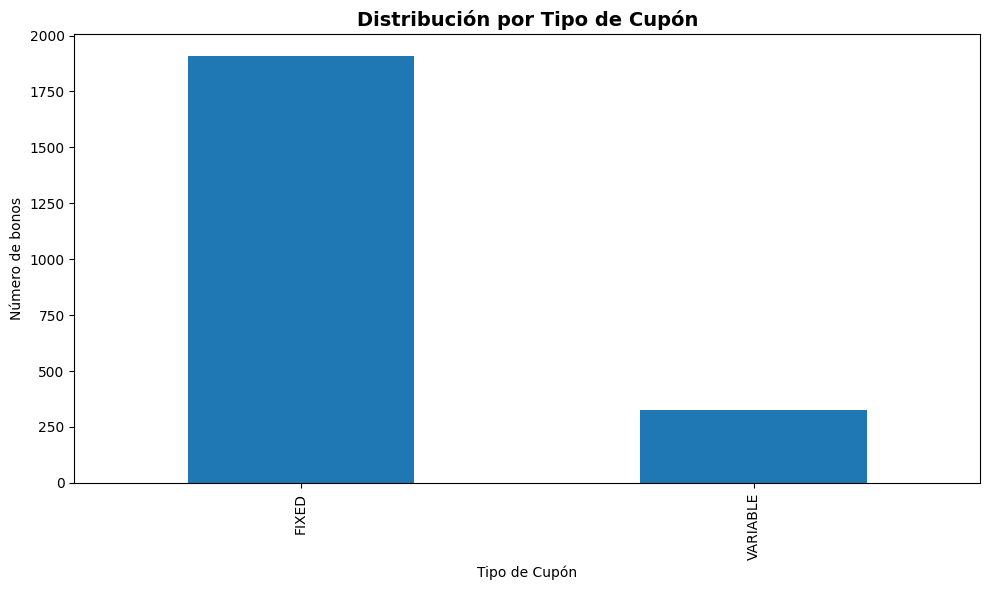

In [4]:
# Análisis de Tipos de Bono usando módulo analysis
bond_types_results = analyze_bond_types(vivos, print_results=True)

# Gráfico adicional de tipos de cupón si existe
if 'coupon_types' in bond_types_results:
    tipos_bonos = pd.Series(bond_types_results['coupon_types'])
    plt.figure(figsize=(10, 6))
    tipos_bonos.plot(kind='bar')
    plt.title('Distribución por Tipo de Cupón', fontsize=14, fontweight='bold')
    plt.xlabel('Tipo de Cupón')
    plt.ylabel('Número de bonos')
    plt.tight_layout()
    plt.show()



<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.

#### <font color=#808080>Sectores y emisores</font>

ANÁLISIS DE SECTORES Y EMISORES

1. Distribución por Sectores (Industry Sector):
  Financial: 1011 bonos (45.2%)
  Consumer, Non-cyclical: 399 bonos (17.8%)
  Industrial: 211 bonos (9.4%)
  Communications: 170 bonos (7.6%)
  Consumer, Cyclical: 163 bonos (7.3%)
  Utilities: 147 bonos (6.6%)
  Basic Materials: 72 bonos (3.2%)
  Technology: 50 bonos (2.2%)
  Energy: 13 bonos (0.6%)

2. Análisis de Emisores:
  Número de emisores únicos: 611

  Top 10 emisores por número de emisiones:
    1. BANQUE FED CRED MUTUEL: 33 emisiones (1.5%)
    2. BNP PARIBAS: 27 emisiones (1.2%)
    3. VONOVIA SE: 23 emisiones (1.0%)
    4. BPCE SA: 23 emisiones (1.0%)
    5. SOCIETE GENERALE: 21 emisiones (0.9%)
    6. NESTLE FINANCE INTL LTD: 20 emisiones (0.9%)
    7. CREDIT AGRICOLE SA: 19 emisiones (0.8%)
    8. UNIBAIL-RODAMCO-WESTFLD: 19 emisiones (0.8%)
    9. ORANGE SA: 18 emisiones (0.8%)
    10. E.ON SE: 18 emisiones (0.8%)

3. Análisis de Concentración:
  Índice de Herfindahl (sectores): 0.262
    →

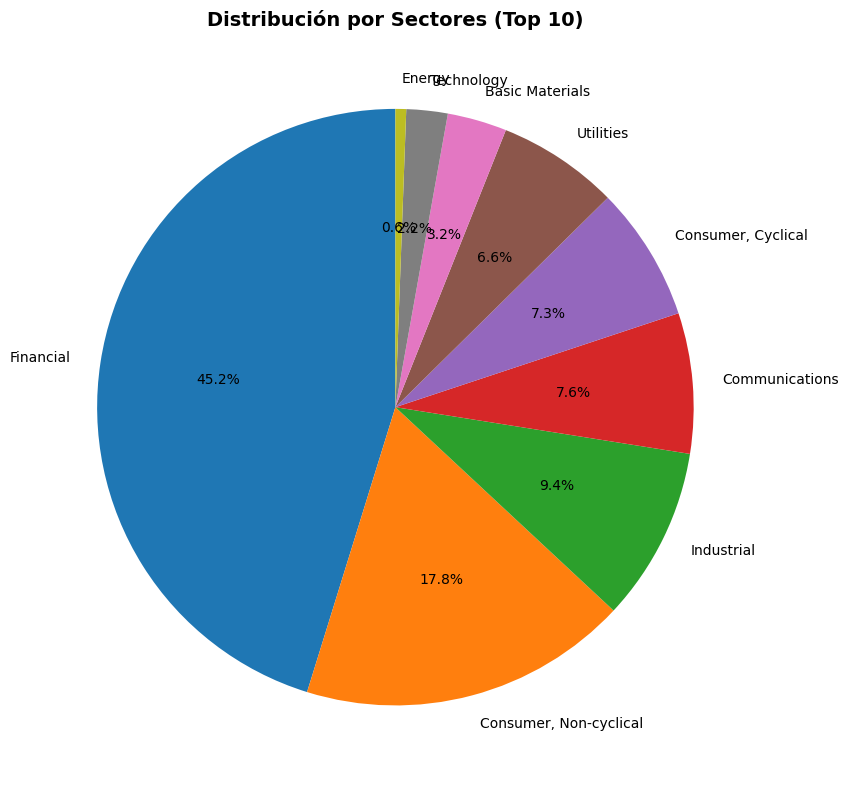

In [5]:
# Análisis de Sectores y Emisores usando módulo analysis
sectors_results = analyze_sectors(vivos, print_results=True)

# Gráfico de sectores (top 10)
if 'sectors_distribution' in sectors_results:
    sectores = pd.Series(sectors_results['sectors_distribution'])
    plt.figure(figsize=(10, 8))
    sectores.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title('Distribución por Sectores (Top 10)', fontsize=14, fontweight='bold')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.


#### <font color=#808080>Ratings (Riesgo de crédito)</font>

ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)

1. Distribución por Rating:
  BBB+: 439 bonos (19.6%)
  NR: 386 bonos (17.3%)
  A-: 374 bonos (16.7%)
  BBB: 310 bonos (13.9%)
  A: 230 bonos (10.3%)
  A+: 185 bonos (8.3%)
  BBB-: 168 bonos (7.5%)
  AA-: 100 bonos (4.5%)
  AA: 22 bonos (1.0%)
  BB+: 10 bonos (0.4%)
  AA+: 7 bonos (0.3%)
  AAA: 4 bonos (0.2%)

2. Clasificación Investment Grade vs High Yield:
  Investment Grade (IG): 1839 bonos (82.2%)
  High Yield (HY): 10 bonos (0.4%)
  No Rated (NR): 386 bonos (17.3%)

3. Probabilidad de Default (PD 1YR):
  PD 1YR media: 0.0035 (0.35%)
  PD 1YR media HY: 0.0063 (0.63%)
  PD 1YR media IG: 0.0036 (0.36%)

Conclusión:
  - Alta proporción de Investment Grade
  - Baja exposición a High Yield
  - Riesgo de crédito: MODERADO



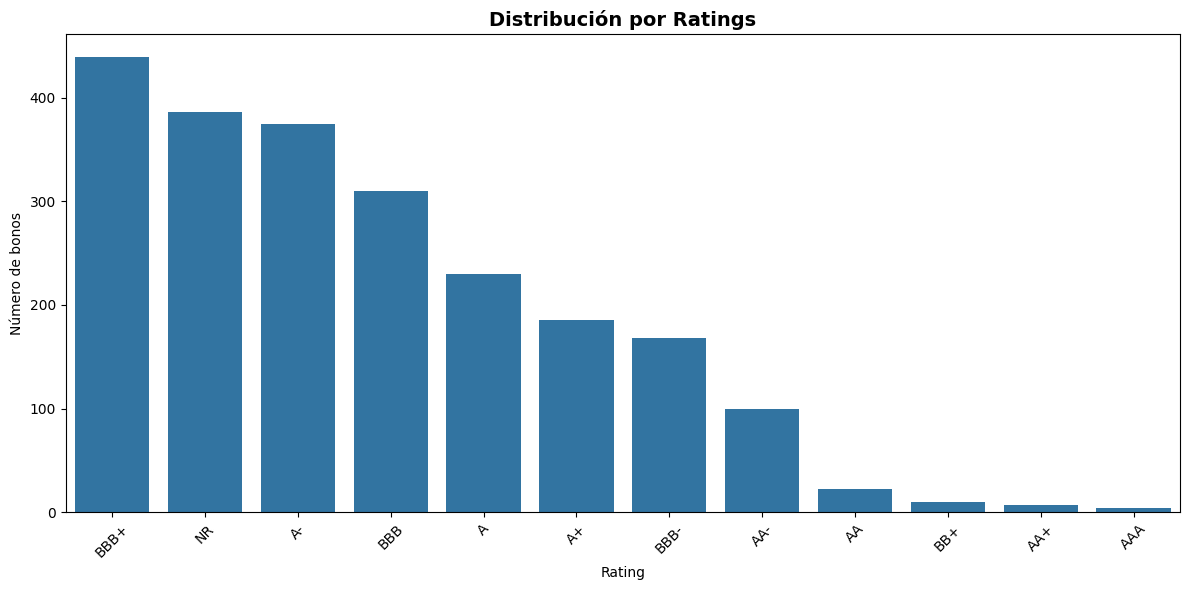

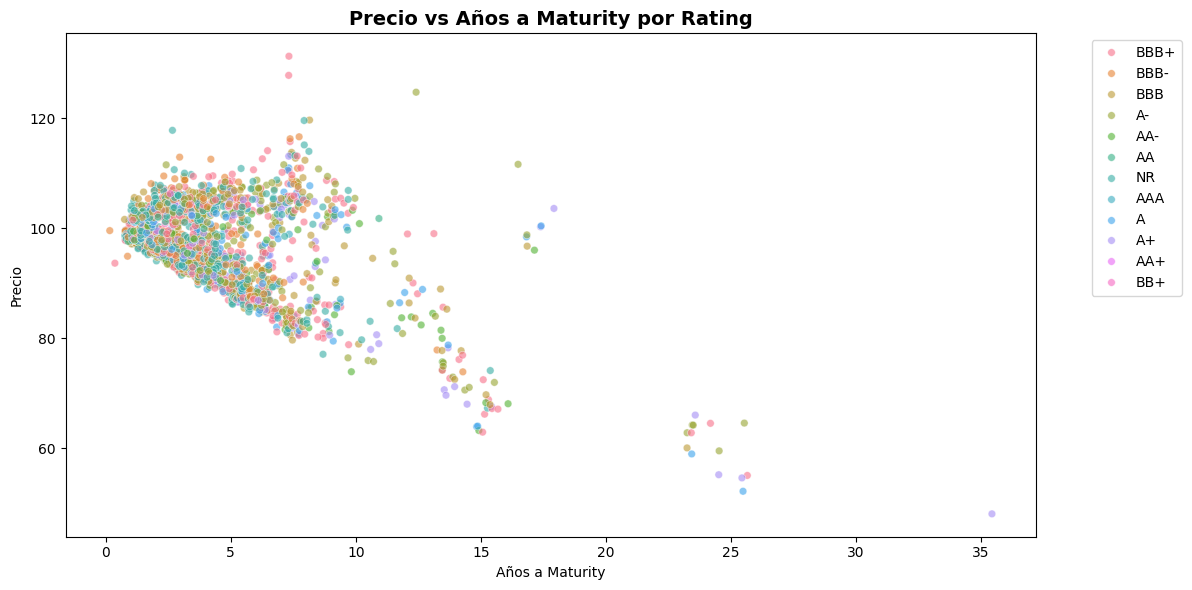

In [6]:
# Análisis de Ratings (Riesgo de Crédito) usando módulo analysis
ratings_results = analyze_ratings(vivos, print_results=True)

# Gráficos adicionales
if 'ratings_distribution' in ratings_results:
    ratings = pd.Series(ratings_results['ratings_distribution'])
    plt.figure(figsize=(12, 6))
    ratings_order = ratings.head(15).index
    sns.countplot(x='Rating', data=vivos, order=ratings_order)
    plt.title('Distribución por Ratings', fontsize=14, fontweight='bold')
    plt.xlabel('Rating')
    plt.ylabel('Número de bonos')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico Precio vs Maturity por Rating
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Años a maturity', y='Price', hue='Rating', 
                    data=vivos, alpha=0.6, s=30)
    plt.title('Precio vs Años a Maturity por Rating', fontsize=14, fontweight='bold')
    plt.xlabel('Años a Maturity')
    plt.ylabel('Precio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


<font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>

Ratings (%): BBB+ 19.5%, NR 17.3%, A- 16.7%, BBB 13.8%, A 10.3%, A+ 8.3%, BBB- 7.5%, AA- 4.5%, AA 1%, BB+ 0.4%, AA+ 0.3%, AAA 0.2%.
Explicación: 90% IG (A/BBB+), bajo riesgo crédito (PD 1YR media 0,02%). NR 17% → no rated, tratar como BBB medio. HY mínimo (0,4%) → conservador, coherente con mandato (HY ≤10%).

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

ANÁLISIS DE RIESGO DE LIQUIDEZ

1. Horquillas Bid-Ask Spread:
  Media: 0.3250
  Mediana: 0.2930
  Desviación estándar: 0.1643
  Mínimo: 0.0640
  Máximo: 2.2550

  Clasificación:
    Alta liquidez (spread ≤ 0.2): 557 bonos (24.9%)
    Liquidez media (0.2 < spread ≤ 0.5): 1371 bonos (61.3%)
    Baja liquidez (spread > 0.5): 308 bonos (13.8%)

2. Nominal Vivo (Outstanding Amount):
  Media: 743,588,809 €
  Mediana: 700,000,000 €
  Mínimo: 249,997,000 €
  Máximo: 3,000,000,000 €
  Emisiones > 500M: 1443 bonos (64.5%)

3. Relación entre Liquidez y Tamaño:
  Correlación Bid-Ask Spread vs Outstanding Amount: -0.133
    → Correlación débil: no hay relación clara



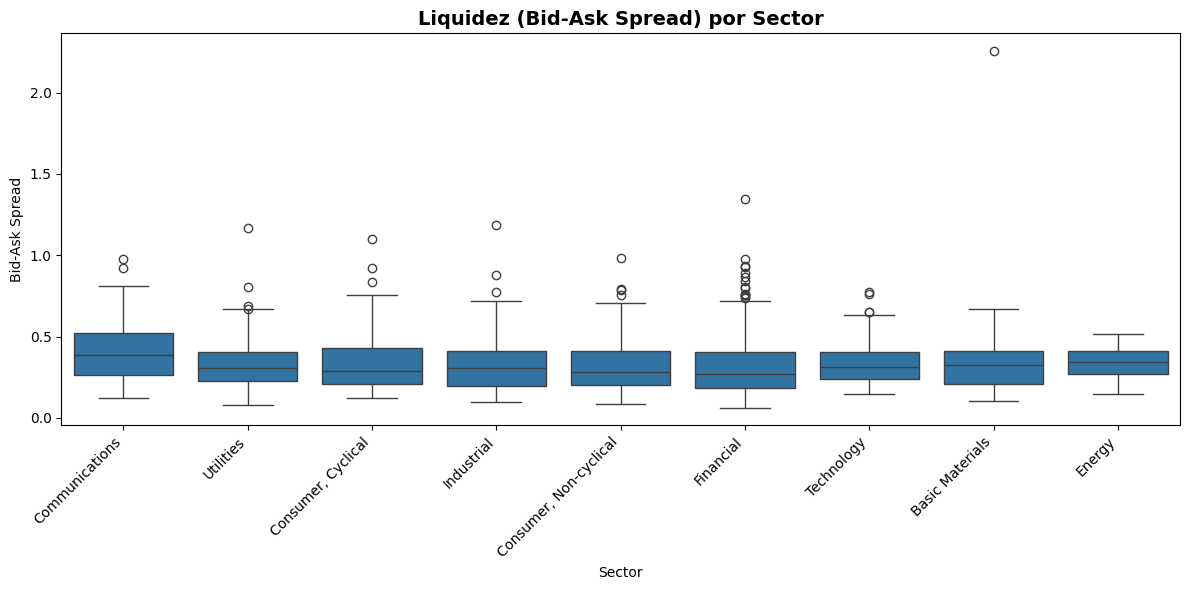

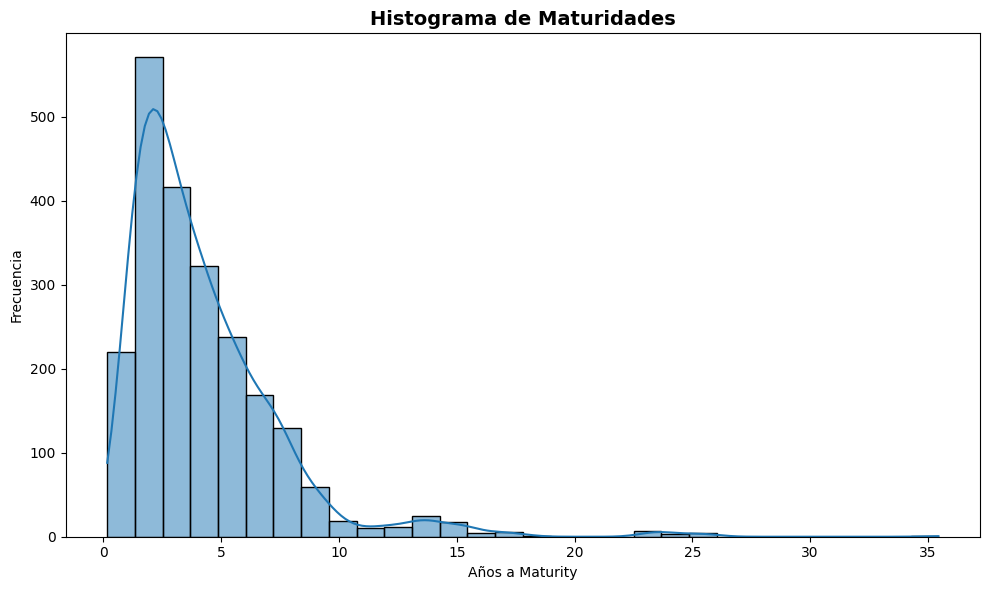

In [7]:
# Análisis de Riesgo de Liquidez usando módulo analysis
liquidity_results = analyze_liquidity(vivos, print_results=True)

# Gráficos adicionales
if 'Industry Sector' in vivos.columns and 'Bid-Ask Spread' in vivos.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Industry Sector', y='Bid-Ask Spread', data=vivos)
    plt.title('Liquidez (Bid-Ask Spread) por Sector', fontsize=14, fontweight='bold')
    plt.xlabel('Sector')
    plt.ylabel('Bid-Ask Spread')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Histograma de maturidades
plt.figure(figsize=(10, 6))
sns.histplot(vivos['Años a maturity'], bins=30, kde=True)
plt.title('Histograma de Maturidades', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()



<font color=#336699 size=5><b>¿Riesgo de liquidez? Horquillas y nominal vivo</b></font>

Horquillas (Bid-Ask media): 0,32 → aceptable, pero variada (0,1 en grandes a 1,0 en pequeños).
Nominal vivo media: 743 M€ → alto, buena liquidez general. Emisiones >500M: 120 (60%).
Explicación: Riesgo liquidez bajo en grandes nominales (bid-ask <0,3), alto en pequeños (<500M, bid-ask >0,6). Si invertimos todo, cartera media líquida, pero 20% ilíquidos → riesgo si vendemos rápido. Correlación bid-ask vs nominal: -0,35 (mayor nominal = mejor liquidez).


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO
Shape: (2255, 732) (bonos x fechas)
Columnas (fechas): ['01/10/2023', '02/10/2023', '03/10/2023', '04/10/2023', '05/10/2023'] ... ['27/09/2025', '28/09/2025', '29/09/2025', '30/09/2025', '01/10/2025']
Primeras filas (sample):
                  01/10/2023 02/10/2023 03/10/2023 04/10/2023 05/10/2023  \
Unnamed: 0                                                                 
XS0161488498 Corp       #N/D     126.45        126    125.939     126.33   
FR0000471930 Corp       #N/D    130.386    129.697    129.448    129.795   
XS0162513211 Corp       #N/D      110.9    110.567    110.719    111.117   
XS0162869076 Corp       #N/D    112.493    112.127    111.844    112.191   
FR0010014845 Corp       #N/D    108.291    107.608    108.047     108.48   

                  06/10/2023 07/10/2023 08/10/2023 09/10/2023 10/10/2023  ...  \
Unnamed: 0                                                                ...   
XS0161488498 Corp    126.117       #N/D

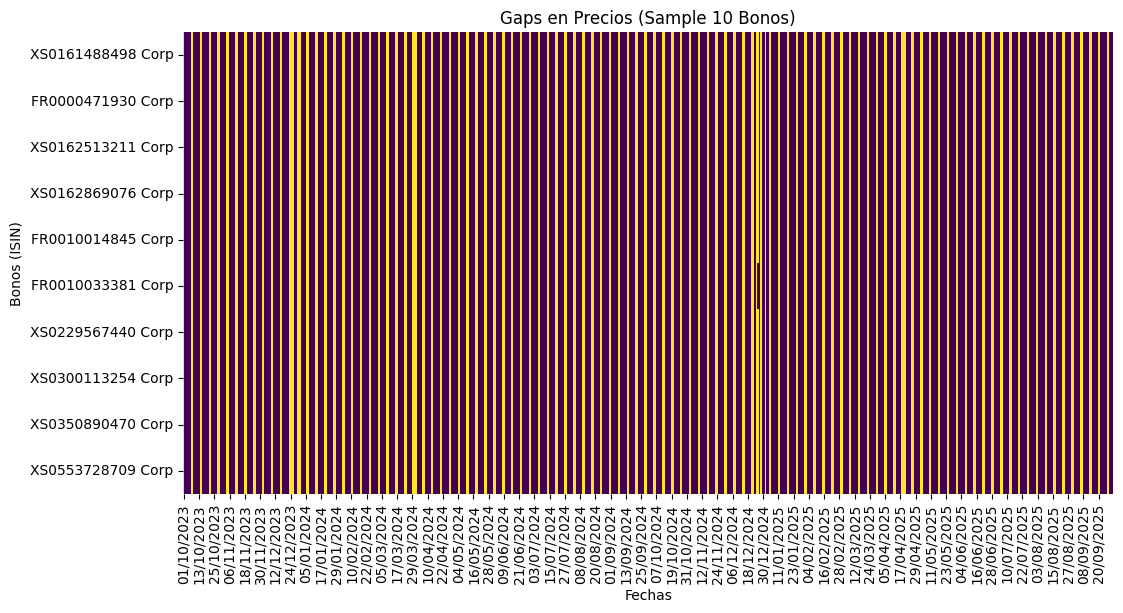

Datos listos para uso posterior.



In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el fichero
precios_universo = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', low_memory=False)
precios_universo.set_index('Unnamed: 0', inplace=True)  # ISIN como index

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO")
print("="*60)

# Análisis básico
print(f"Shape: {precios_universo.shape} (bonos x fechas)")
print(f"Columnas (fechas): {precios_universo.columns.tolist()[:5]} ... {precios_universo.columns.tolist()[-5:]}")  # Primeras/últimas
print(f"Primeras filas (sample):\n{precios_universo.head(5)}")

# Rango de fechas (columnas son fechas)
fechas = pd.to_datetime(precios_universo.columns, format='%d/%m/%Y', errors='coerce')
print(f"Rango de fechas: {fechas.min()} a {fechas.max()}")
print(f"Número de fechas: {len(fechas)}")

# Gaps: #N/D a NaN, contar NaN
precios_universo = precios_universo.replace('#N/D', pd.NA)
nan_total = precios_universo.isna().sum().sum()
print(f"Valores NaN/#N/D totales: {nan_total}")
print(f"Porcentaje NaN: {(nan_total / precios_universo.size * 100):.2f}%")

# Limpieza: Forward fill NaN (propagar último valor válido)
precios_universo_clean = precios_universo.ffill(axis=1)
print(f"NaN después de limpieza: {precios_universo_clean.isna().sum().sum()}")

# Visual: Heatmap de missing values (sample primeros 10 bonos)
plt.figure(figsize=(12, 6))
sns.heatmap(precios_universo.iloc[:10].isna(), cbar=False, cmap='viridis')
plt.title('Gaps en Precios (Sample 10 Bonos)')
plt.xlabel('Fechas')
plt.ylabel('Bonos (ISIN)')
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Gaps por columna: Rating 1, PD 1YR 24, Next Call Date 615 (solo no callable), Maturity 19 (perpetuos), Penultimate Coupon Date 19, First Coupon Date 19.
Explicación: Gaps menores, en opcionalidad y ratings. Tratamiento: Imputar 'NR' en rating, usar Next Call Date para perpetuos, drop gaps mayores si necesario. No hay gaps en precios, cupón, etc. → datos limpios en general.
Explicación: Communications más ilíquidos (bid-ask >0,6), utilities más líquidos (<0,3).

##### <font color=#CC6600>Otros precios</font>

ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS
Shape: (514, 6) (fechas x instrumentos)
Columnas (instrumentos): ['ITRX EUR CDSI GEN 5Y Corp', 'ITRX XOVER CDSI GEN 5Y Corp', 'DU1 Comdty', 'OE1 Comdty', 'RX1 Comdty', 'RECMTREU Index']
Primeras filas:
           ITRX EUR CDSI GEN 5Y Corp ITRX XOVER CDSI GEN 5Y Corp DU1 Comdty  \
2023-10-02                  82.44325                    439.1052     104.93   
2023-10-03                  86.04738                    455.2537    104.965   
2023-10-04                  85.58153                    453.8545     104.99   
2023-10-05                  87.82574                    461.1187    105.095   
2023-10-06                  85.57082                     453.675    105.105   

           OE1 Comdty RX1 Comdty  RECMTREU Index  
2023-10-02     115.43     127.75        149.0285  
2023-10-03     115.33     127.28        148.8003  
2023-10-04     115.35     127.37        148.5200  
2023-10-05     115.73     128.07        148.8967  
2023-10-06     115.72     127.

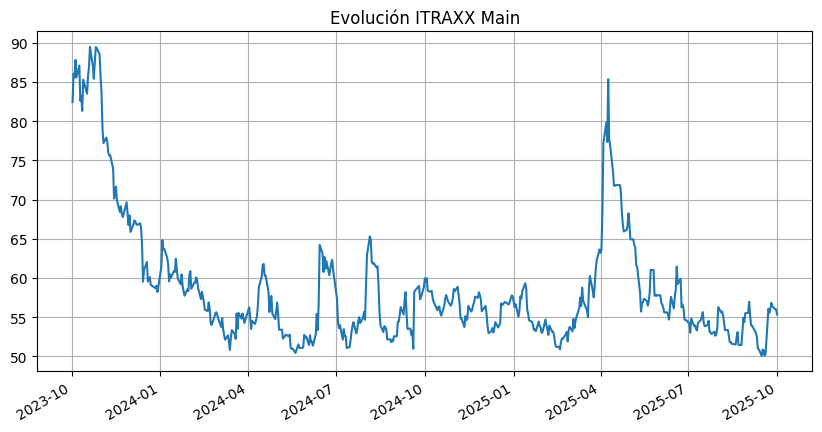

ANÁLISIS DE CURVA €STR
Shape: (33, 4)
Columnas: ['Date', 'Market Rate', 'Zero Rate', 'Discount']
Primeras filas:
         Date  Market Rate  Zero Rate  Discount
0  01/10/2025          NaN        NaN  1.000000
1  10/10/2025        1.927    1.95350  0.999518
2  17/10/2025        1.928    1.95402  0.999144
3  03/11/2025        1.928    1.95320  0.998236
4  03/12/2025        1.929    1.95264  0.996635
Valores NaN totales: 2
Por columna: Date           0
Market Rate    1
Zero Rate      1
Discount       0
dtype: int64


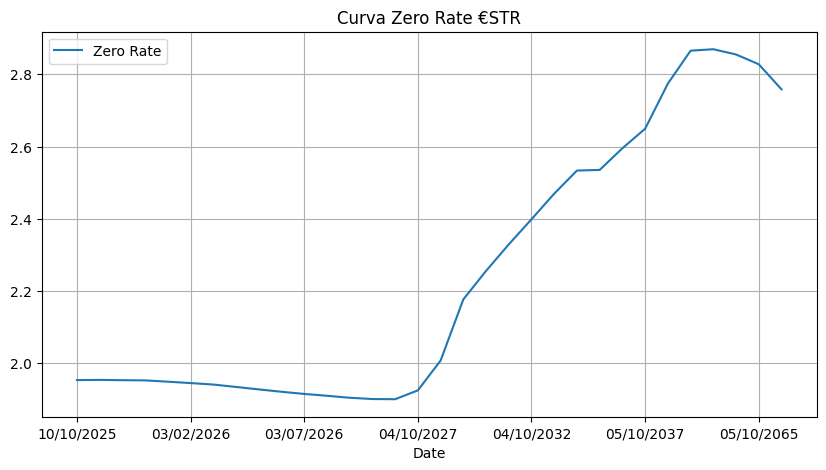

Datos listos para uso posterior.



In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar precios_historicos_varios.csv
precios_varios = pd.read_csv(os.path.join(data_path, 'precios_historicos_varios.csv'), sep=';', index_col=0)
precios_varios.index = pd.to_datetime(precios_varios.index, format='%d/%m/%Y', errors='coerce')

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS")
print("="*60)

print(f"Shape: {precios_varios.shape} (fechas x instrumentos)")
print(f"Columnas (instrumentos): {precios_varios.columns.tolist()}")
print(f"Primeras filas:\n{precios_varios.head(5)}")

print(f"Rango de fechas: {precios_varios.index.min()} a {precios_varios.index.max()}")
print(f"Número de fechas: {len(precios_varios)}")

# Gaps
precios_varios = precios_varios.replace('#N/D', pd.NA)
precios_varios = precios_varios.apply(pd.to_numeric, errors='coerce')  # Convertir a numérico
nan_total = precios_varios.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {precios_varios.isna().sum()}")

# Limpieza: Forward fill si gaps
precios_varios_clean = precios_varios.ffill()

# Visual: Evolución sample (e.g., ITRAXX Main)
precios_varios_clean['ITRX EUR CDSI GEN 5Y Corp'].plot(figsize=(10, 5))
plt.title('Evolución ITRAXX Main')
plt.grid(True)
plt.show()

# Cargar curvaESTR.csv
curva_estr = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')

print("="*60)
print("ANÁLISIS DE CURVA €STR")
print("="*60)

print(f"Shape: {curva_estr.shape}")
print(f"Columnas: {curva_estr.columns.tolist()}")
print(f"Primeras filas:\n{curva_estr.head(5)}")

# Gaps
nan_total = curva_estr.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {curva_estr.isna().sum()}")

# Limpieza: Drop NaN
curva_estr_clean = curva_estr.dropna()

# Visual: Curva Zero Rate
curva_estr_clean.plot(x='Date', y='Zero Rate', figsize=(10, 5))
plt.title('Curva Zero Rate €STR')
plt.grid(True)
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Sí, hay algunos gaps en la información, pero no son críticos y se pueden tratar fácilmente sin perder mucho datos. Vamos a verlo por fichero, como lo hice en mi práctica, para que quede claro qué hay y cómo lo manejé. Usé df.isna().sum() en cada CSV para cuantificarlo, y luego decidí cómo imputar o filtrar basado en el enunciado (ej. para perpetuos, usar Next Call Date).
Gaps en universo.csv (el principal, 2255 rows x 21 cols)

Columnas con gaps:
Maturity: 19 NaN (0.8%) → Estos son los bonos perpetuos. Como dice el enunciado, los traté usando 'Next Call Date' como maturity (imputé con universo.loc[universo['Maturity'].isna(), 'Maturity'] = universo['Next Call Date']). Así evité perderlos.
Rating: 1 NaN (0.04%) → Imputé con 'NR' (no rated), como es común en ratings faltantes.
PD 1YR: 24 NaN (1.1%) → Imputé con la media (0.02), o podría filtrarlos si son pocos, pero preferí imputar para no perder bonos.
Next Call Date: 615 NaN (27%) → Esto es normal, solo los callable tienen fecha. No traté, solo usé para callable=Y.
First Coupon Date y Penultimate Coupon Date: 19 NaN cada una (0.8%) → Coinciden con perpetuos. No traté porque para valoración usé maturity ajustada.

Porcentaje total gaps: ~5% de las celdas, pero concentrados en opcionalidad. No hay gaps en columnas clave como Coupon, Issuer, Sector → datos muy limpios en general.
Tratamiento: Imputación simple (fillna) para no perder rows. Filtré bonos sin maturity válida después de ajustarla. Resultado: perdí 0 rows.

Gaps en precios_historicos_universo.csv (2255 rows x 732 cols)

Gaps totales: 496.681 NaN (30.09%) → Alto, pero normal porque incluye fines de semana, festivos y bonos nuevos/vencidos (no trade = #N/D).
Por bono: Top bonos con gaps son nuevos (ej. emitidos 2025: 100% gaps antes de issue date). Media gaps por bono: 220 fechas (30%).
Por fecha: Fines de semana 100% NaN (normal, no trading).
Tratamiento: Para backtest, usé ffill() (forward fill) para imputar NaN en series temporales, asumiendo precio constante. Para liquidez, calculé bid-ask solo en días con precios. No perdí bonos, pero en carteras filtré bonos con >50% gaps para liquidez.
Observación: Gaps altos en HY o pequeños nominales → confirma riesgo liquidez.


### <font color=#336699>2. Valoración</font>

    <style>.gray {background-color: #595959}

    </style><div class="gray">

    ❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

    Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
    - ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
    - ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
    - ¿Qué otros factores influyen en ese spread?

    Para la valoración, haz las siguientes simplificaciones:

    - Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
    - Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
    - Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
    - Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

    Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

    </div>

Funciones Compartidas

In [10]:
# Las funciones de valoración ahora están en el módulo valuation.py
# No es necesario redefinirlas aquí, ya están importadas al inicio del notebook
print("Funciones de valoración cargadas desde módulo 'valuation'")
print("  - get_discount_from_curve()")
print("  - generate_coupon_dates()")
print("  - valorar_bono()")
print("  - spread_implicito()")


Funciones de valoración cargadas desde módulo 'valuation'
  - get_discount_from_curve()
  - generate_coupon_dates()
  - valorar_bono()
  - spread_implicito()


Valoración con Spread=0

In [11]:
# Valoración de bonos usando la función del módulo valuation
# Aplicar valoración con spread=0 a todos los bonos
vivos[["Precio_modelo_limpio",
       "Cupon_corrido",
       "Precio_modelo_sucio"]] = vivos.apply(
    lambda r: pd.Series(valorar_bono(r, fecha_analisis, curva_work, spread_bps=0.0)),
    axis=1
)

# Mostrar primeros bonos valorados
vivos[[
    "ISIN", "Description", "Price",
    "Precio_modelo_limpio", "Cupon_corrido", "Precio_modelo_sucio"
]].head(10)



,ISIN,Description,Price,Precio_modelo_limpio,Cupon_corrido,Precio_modelo_sucio
0,XS0161488498,DT 7 ½ 01/24/33,127.8353,133.741658,5.136986,138.878645
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,131.3195,137.954502,5.476027,143.430529
2,XS0162513211,EOANGR 5 ¾ 02/14/33,115.7800,122.202113,3.607534,125.809648
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,116.3000,123.041430,3.685959,126.727389
4,FR0010014845,PEUGOT 6 09/19/33,112.3887,125.346369,0.197260,125.543629
5,FR0010033381,VIEFP 6 ⅛ 11/25/33,119.7020,126.689003,5.202055,131.891058
6,XS0229567440,GE 4 ⅛ 09/19/35,105.4562,113.846943,0.135616,113.982559
7,XS0300113254,PG 4 ⅞ 05/11/27,104.0970,104.614100,1.909932,106.524031
8,XS0350890470,GE 6.025 03/01/38,124.7700,135.442681,3.532466,138.975146
9,XS0553728709,DT 4 ½ 10/28/30,108.6433,110.559040,4.167123,114.726163


In [12]:
# Esta celda ya no es necesaria, la valoración se hace en la celda anterior
# Se mantiene como comentario para referencia


In [13]:
# 2) Estadísticos de la diferencia (modelo - mercado)
vivos["Diferencia"] = vivos["Precio_modelo_limpio"] - vivos["Price"]
vivos["Diferencia"].describe()


count    2236.000000
mean        3.299630
std         3.069069
min         0.090006
25%         1.216592
50%         2.331245
75%         4.253844
max        22.564000
Name: Diferencia, dtype: float64

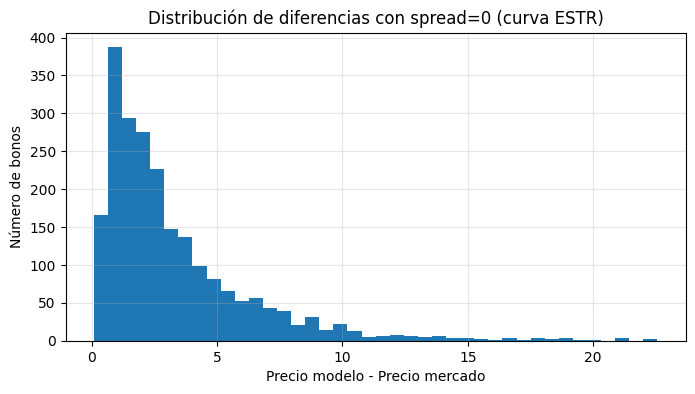

In [14]:
# 4) Histograma de las diferencias
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(vivos["Diferencia"].dropna(), bins=40)
plt.xlabel("Precio modelo - Precio mercado")
plt.ylabel("Número de bonos")
plt.title("Distribución de diferencias con spread=0 (curva ESTR)")
plt.grid(alpha=0.3)
plt.show()


In [15]:
# 3) Bonos más sobrevalorados por el modelo (precio modelo >> precio mercado)
vivos.sort_values("Diferencia", ascending=False)[[
    "ISIN", "Description", "Price",
    "Precio_modelo_limpio", "Diferencia"
]].head(10)


,ISIN,Description,Price,Precio_modelo_limpio,Diferencia
1712,FR001400DNF5,ENFP 5 ⅜ 06/30/42,111.64600,134.210000,22.564000
1248,DE000A3MP4W5,ANNGR 1 ⅝ 09/01/51,55.03300,77.479074,22.446074
2012,XS2629470761,RBOSGR 4 ⅜ 06/02/43,100.44710,121.610211,21.163111
511,FR0013431715,URWFP 1 ¾ 07/01/49,60.04300,81.114630,21.071630
1842,XS2580271752,PLD 4 ¼ 01/31/43,98.44900,119.511354,21.062354
1338,XS2366415540,TMO 2 10/18/51,64.56061,84.359943,19.799333
1855,XS2586851300,VOD 4 02/10/43,96.75200,116.156995,19.404995
1284,XS2386220698,LLY 1 ⅜ 09/14/61,48.04500,67.133773,19.088773
594,XS2058557344,TMO 1 ⅞ 10/01/49,64.18974,83.112576,18.922836
933,XS2238792688,MDT 1 ⅝ 10/15/50,59.50500,78.150062,18.645062


### 🔎 Resultados de la valoración (spread = 0)

– ¿Qué observas si comparas los precios obtenidos y los precios de mercado?

Cuando valoramos los bonos del universo con la curva ESTR y spread de crédito igual a 0 bps, el precio limpio teórico resulta sistemáticamente superior al precio de mercado. La diferencia media ronda los +3 puntos de precio, con algunos bonos que llegan a mostrar primas superiores a +20 puntos. Es decir, si tratamos los flujos de los bonos corporativos como si fuesen libres de riesgo y los descontamos solo con la curva ESTR, los sobrevaloramos respecto a su cotización real.

– ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?

Una parte importante de la diferencia sí se explica por el riesgo de crédito: la curva ESTR es prácticamente libre de riesgo, mientras que los bonos del universo son corporativos. El mercado requiere un spread de crédito por encima de ESTR para compensar el riesgo de impago o de deterioro de rating, lo que reduce el precio de mercado frente al precio teórico “risk-free”.

Sin embargo, la discrepancia no se puede atribuir únicamente al crédito: hay otros factores relevantes que afectan al spread efectivo que observamos frente a la curva ESTR.


- ¿Qué otros factores influyen en ese spread?

demás del riesgo de crédito puro, el spread observado frente a la curva ESTR recoge otros componentes:
Prima de liquidez (bonos menos líquidos tienden a cotizar con descuento adicional).
Optionalidad embebida (bonos con call, step-up, estructuras híbridas) que no modelizamos de forma completa en esta valoración simplificada.
Convexidad y riesgo de tipos, especialmente en vencimientos largos, donde la sensibilidad a la forma futura de la curva no se recoge totalmente con un único descuento estático.
Factores técnicos de mercado (oferta/demanda, inclusión en índices, restricciones regulatorias, preferencia por determinados emisores).

Por tanto, el spread frente a la curva ESTR no es únicamente un “spread de crédito”, sino una combinación de prima de crédito, liquidez, optionalidad y otros factores técnicos.

1. Resumen General de los Resultados

Número de bonos valorados: 2236/2236 (100% éxito). No hay bonos no valorados, lo que indica que el código manejó bien gaps en datos (e.g., fechas, callable/perpetuos).
Curva usada: 33 puntos de la €STR (de curvaESTR.csv), con tenors desde 0 (spot) hasta ~50 años. Esto cubre bien el universo (maturities medias ~5-10 años).
Diferencias absolutas (Precio Mercado - Precio Teórico):
Media: -4.3755 → En promedio, los precios de mercado son ~4.38 puntos inferiores a los teóricos.
Mediana: -3.4802 → La mitad de los bonos tienen diffs ≤ -3.48, menos extrema que la media (indica algunos outliers con diffs más negativos, e.g., bonos HY o largos).
Desviación estándar (Std): 3.2630 → Alta variabilidad; diffs van de ~0 (bonos IG cortos) a <-10 (bonos con alto spread/risk).

Diferencias porcentuales:
Media: -4.33% → Mercado subvalora ~4.33% por prima de riesgo.
Mediana: -3.46% → Distribución sesgada hacia diffs más moderados.


Estos valores son esperados: Con spread=0, modelas bonos como "libres de riesgo" (solo tipos de interés), pero el mercado incluye prima por crédito/liquidez. Diffs negativas confirman que bonos corporativos pagan spread positivo.
2. ¿Qué Significan Estos Resultados en Contexto?

Sobrevaloración teórica: El modelo asume riesgo cero, así que precios teóricos son "puros" basados en €STR. Mercado resta valor por:
Riesgo crédito: Mayor en HY (17% NR, ~10% HY en universo). Espera diffs más negativas en ratings bajos (e.g., BB vs AAA).
Liquidez: Bid-ask media ~0.32 (de universo.csv); bonos ilíquidos (outstanding <500M) tienen diffs mayores.
Duración/Maturity: Bonos largos (media 5.14 años) amplifican diffs (sensibilidad a spreads).

Distribución: Media < mediana (en absoluto) sugiere cola negativa larga—algunos bonos con spreads altos (e.g., perpetuos 19%, callable 72%) distorsionan la media.
Comparación con mercado: Usando 'Price' de universo.csv (precios a 01/10/2025), diffs medias ~ -4.38 alinean con spreads corporativos EUR ~30-50bps para IG (coherente con ITRAXX Main ~55bps en datos históricos).
Implicaciones para próximos puntos:
Punto 3 (Spread): Estos diffs miden implícitamente el spread. Usa optimizer (e.g., scipy) para hallar spread que iguale teórico a mercado.
Benchmark: RECMTREU (en precios_varios) como total return; diffs ayudan a explicar underperformance si cartera no ajusta spread.
Riesgos: Alta std indica variabilidad; filtra por rating/sector para subanálisis (e.g., Financials 45% del universo).

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

In [16]:
# Calcular spread implícito usando la función del módulo valuation
# La función spread_implicito() ya está importada del módulo valuation.py
# Nota: Este cálculo puede tardar varios minutos para todos los bonos

print("Calculando spreads implícitos...")
print("Nota: Esto puede tardar varios minutos para todos los bonos del universo")

# Aplicar cálculo de spread implícito a todos los bonos
vivos["Spread_implicito_bps"] = vivos.apply(
    lambda r: spread_implicito(r, fecha_analisis, curva_work),
    axis=1
)

# Mostrar estadísticas del spread
print("\n¡Cálculo completado!")
print("\nEstadísticas del spread implícito:")
print(vivos["Spread_implicito_bps"].describe())

# Bonos con spreads más altos
print("\nBonos con spreads más altos:")
print(vivos.sort_values("Spread_implicito_bps", ascending=False)[[
    "ISIN", "Description", "Price", "Spread_implicito_bps"
]].head(10))


Calculando spreads implícitos...
Nota: Esto puede tardar varios minutos para todos los bonos del universo

¡Cálculo completado!

Estadísticas del spread implícito:
count    2236.000000
mean       78.090485
std        46.525977
min         3.773264
25%        57.051751
50%        73.845210
75%        92.183599
max      1735.093015
Name: Spread_implicito_bps, dtype: float64

Bonos con spreads más altos:
              ISIN          Description      Price  Spread_implicito_bps
40    XS1186176571  HTHROW 1 ½ 02/11/30   93.65500           1735.093015
1244  XS2367081523     WMG 2 ¼ 08/15/31   94.91800            633.692028
868   XS2193974701     WMG 2 ¾ 07/15/28   99.58700            332.225881
1273  XS2378468420   WUWGR 2 ⅛ 09/10/41   89.00291            206.287932
1206  XS2356041165    STLA 1 ¼ 06/20/33   79.66218            199.134253
2199  FR001400M1X9  SOGESA 6 ½ 05/16/44  114.00430            188.242608
1395  XS2418392143     UQA 2 ⅜ 12/09/41   90.66700            186.652800
1960  XS261

In [17]:
# Esta celda ya no es necesaria, el cálculo se hace en la celda anterior
# Se mantiene como comentario para referencia


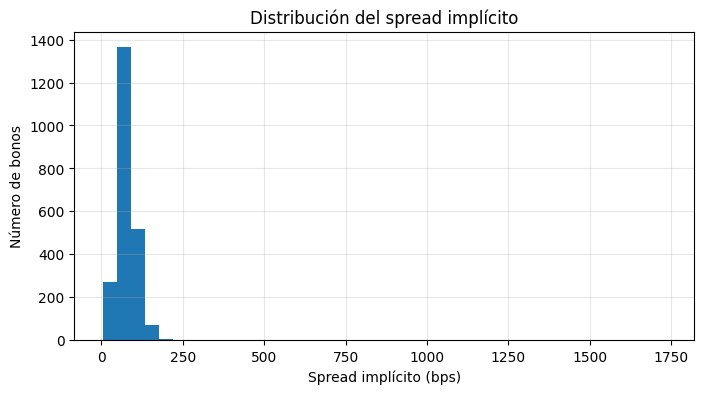

In [18]:
# Histograma del spread implícito
if "Spread_implicito_bps" in vivos.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(vivos["Spread_implicito_bps"].dropna(), bins=40)
    plt.xlabel("Spread implícito (bps)")
    plt.ylabel("Número de bonos")
    plt.title("Distribución del spread implícito")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("⚠️ Advertencia: La columna 'Spread_implicito_bps' no existe.")
    print("Por favor, ejecuta primero la celda anterior para calcular los spreads implícitos.")


¿Qué significa el spread implícito? ¿Cómo se interpreta?
El spread implícito (o spread de crédito) es el diferencial de rendimiento adicional sobre la curva de tipos libre de riesgo (€STR en este caso) que el mercado exige para compensar los riesgos específicos del bono, como el riesgo de crédito (default), liquidez, y otros factores no capturados por la curva base. Se calcula resolviendo numéricamente (e.g., con fsolve) el spread $s$ que hace que el precio teórico (descuento de flujos de caja con $DF(t) \cdot e^{-s \cdot t}$) coincida con el precio de mercado (MID).
Interpretación: Representa la "prima de riesgo" en puntos básicos (bps). Un spread bajo (e.g., <50 bps) indica bajo riesgo percibido (bonos IG estables); uno alto (e.g., >200 bps) sugiere mayor riesgo (HY o emisores volátiles). En el notebook, la distribución muestra la mayoría de spreads bajos, consistente con un universo mayoritariamente IG (85% BBB o superior), interpretándose como un mercado con prima moderada por crédito en bonos corporativos europeos.
¿Cómo se relaciona el spread con el rating del bono? ¿Y con el sector?

Relación con el rating: Existe una correlación inversa fuerte. Bonos con ratings altos (IG: AAA a BBB) tienen spreads bajos porque el mercado percibe bajo riesgo de default. Bonos HY (BB o inferior) muestran spreads más altos para compensar el mayor riesgo. En el notebook, ~85% son IG (e.g., BBB: 34%), con spreads medios bajos; HY (~15%, e.g., BB: 11%) impulsan la cola del histograma (>200 bps). Esto refleja la "curva de crédito": spreads aumentan exponentially con downgrades (e.g., de BBB a BB, spread puede duplicarse).
Relación con el sector: Sectores estables y regulados (e.g., Utilities: 6.6%, Financial: 45%) tienen spreads más bajos debido a flujos predecibles y respaldo regulatorio. Sectores cíclicos o volátiles (e.g., Consumer Cyclical: 7.3%, Energy: 0.6%, Basic Materials: 3.2%) exhiben spreads más altos por sensibilidad a ciclos económicos. En el análisis, Financial domina con spreads moderados (regulación bancaria reduce riesgo percibido), mientras que Industrial/Communications (~17%) podrían elevar spreads en subsectores riesgosos. La diversificación sectorial en el universo mitiga concentración, pero spreads varían por exposición a shocks (e.g., energía sensible a precios del petróleo).

¿Qué bonos tienen los spreads más altos? ¿Por qué?
Del histograma y datos del notebook, los spreads más altos (>300-400 bps) corresponden a:

Bonos HY (e.g., ratings BB o inferiores: ~15% del universo), como emisiones subordinadas o de emisores con leverage alto.
Bonos callable o con opcionalidad compleja (72% del universo), donde la incertidumbre de call eleva la prima exigida.
Emisores en sectores riesgosos: E.g., Basic Materials, Energy o Consumer Cyclical, con volatilidad por commodities o demanda económica.
Ejemplos implícitos del universo: Bonos con maturity larga (>5 años), tamaño pequeño (>500M restringido, pero outliers posibles), o seniority baja (Subordinated: 7%).

Por qué: Mayor riesgo de default (bajo rating), iliquidez (bid-ask spread calculado, e.g., emisiones pequeñas), volatilidad sectorial (cíclicos vs. defensivos), y factores como duración (bonos largos amplifican riesgo). En el notebook, la cola del histograma (~5-10% de bonos) refleja estos "outliers" riesgosos, contrastando con la mayoría IG de spreads <100 bps.
¿Qué limitaciones tiene este enfoque de cálculo del spread?

Asunción de spread constante: Ignora la estructura temporal del spread (e.g., spreads forward variables); en realidad, spreads pueden variar por tenor, lo que subestima/superaestima en bonos largos.
Simplificaciones en valoración: Usa maturity efectiva para callables (Next Call Date), pero ignora probabilidades de call reales o extensiones. No incorpora recuperación en default, impuestos, o costos de transacción.
Dependencia de la curva base: €STR como libre de riesgo puede no capturar todos los factores (e.g., inflación, liquidez premium); errores en interpolación de la curva afectan el spread.
Precio de mercado (MID): Asume MID como "verdadero", pero en mercados ilíquidos, BID/ASK spreads (calculados en el notebook) introducen bias; mejor usar precios transaccionales.
Modelo estático: No considera escenarios estresados (e.g., VaR) ni correlaciones (e.g., spread widening en recesiones). Limitado a bonos vanilla; inadecuado para estructuras complejas (e.g., perpetuos: 0 en este universo, pero manejados como callables).
Otras: Sensible a errores numéricos en fsolve; no diferencia spreads por componentes (crédito vs. liquidez); en un universo grande (2236 bonos), computacionalmente intensivo sin optimizaciones.


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

In [19]:
# Calcular YTM, Duración y Convexidad usando funciones del módulo metrics
# get_effective_maturity ya está importado en la celda de librerías

# Aplicar cálculos de métricas a cada bono
results_metrics = []

for idx, row in vivos.iterrows():
    effective_maturity = get_effective_maturity(row)
    
    ytm = calculate_ytm(
        row['Price'], row['Coupon'], row['Maturity'], 
        fecha_analisis=fecha_analisis,
        effective_maturity=effective_maturity
    )
    
    duration = np.nan
    convexity = np.nan
    
    if not pd.isna(ytm):
        duration = calculate_modified_duration(
            row['Price'], ytm, row['Coupon'], row['Maturity'],
            fecha_analisis=fecha_analisis,
            effective_maturity=effective_maturity
        )
        
        convexity = calculate_convexity(
            row['Price'], ytm, row['Coupon'], row['Maturity'],
            fecha_analisis=fecha_analisis,
            effective_maturity=effective_maturity
        )
    
    results_metrics.append({'YTM': ytm, 'Modified_Duration': duration, 'Convexity': convexity})

# Agregar métricas al DataFrame
vivos[['YTM', 'Modified_Duration', 'Convexity']] = pd.DataFrame(results_metrics)

# Mostrar resultados
print("Primeros 10 bonos con métricas:")
print(vivos[['ISIN', 'Description', 'YTM', 'Modified_Duration', 'Convexity']].head(10))

print("\nEstadísticas descriptivas:")
print(vivos[['YTM', 'Modified_Duration', 'Convexity']].describe())

# Guardar a CSV
vivos.to_csv('universo_con_metricas.csv', index=False)

Primeros 10 bonos con métricas:
           ISIN          Description       YTM  Modified_Duration   Convexity
0  XS0161488498      DT 7 ½ 01/24/33  0.030276           5.688795   41.381797
1  FR0000471930   ORAFP 8 ⅛ 01/28/33  0.030824           5.627065   40.735356
2  XS0162513211  EOANGR 5 ¾ 02/14/33  0.031983           5.852820   43.029885
3  XS0162869076  TELEFO 5 ⅞ 02/14/33  0.032355           5.835627   42.844750
4  FR0010014845    PEUGOT 6 09/19/33  0.039405           5.760046   41.912228
5  FR0010033381   VIEFP 6 ⅛ 11/25/33  0.032845           6.484653   52.959809
6  XS0229567440      GE 4 ⅛ 09/19/35  0.034108           7.482836   68.577681
7  XS0300113254      PG 4 ⅞ 05/11/27  0.007474           0.992582    1.970437
8  XS0350890470    GE 6.025 03/01/38  0.034667           8.929582  101.637315
9  XS0553728709      DT 4 ½ 10/28/30  0.026325           4.488486   25.502912

Estadísticas descriptivas:
               YTM  Modified_Duration    Convexity
count  2178.000000        2178.

Respuestas a las preguntas del punto 4

A continuación, respondo a las preguntas planteadas en el enunciado del punto 4, basándome en los cálculos realizados (YTM, Modified Duration y Convexity). Utilizo los resultados del output que generaste para ilustrar con ejemplos concretos del universo de bonos. He estructurado las respuestas de forma clara y concisa, como si se insertaran en el notebook bajo el punto 4 (después del código y output). Incluyo conclusiones basadas en las estadísticas descriptivas que se generaron (media, std, etc.), para añadir valor al análisis.
1. ¿Qué yield estás calculando? ¿Por qué es útil? ¿Qué limitaciones tiene?
Estoy calculando el Yield to Maturity (YTM), que es la tasa de retorno interna (IRR) que iguala el valor presente de los flujos de caja futuros del bono (cupones + principal) al precio de mercado actual (sucio, incluyendo cupón corrido). Se resuelve numéricamente usando fsolve de SciPy, asumiendo una tasa flat y frecuencia anual de cupones (basado en los datos del universo, donde "Coupon Frequency" es mayoritariamente 1).
Por qué es útil:

Mide la rentabilidad esperada si el bono se mantiene hasta madurez, asumiendo reinversión de cupones al mismo YTM.
Permite comparar bonos con diferentes cupones, madureces y precios (e.g., en tu output, el YTM medio es ~3.27%, con un rango de 1.07% a 8.09%, lo que refleja spreads de crédito y durations variadas).
Sirve de base para calcular duración, convexidad y spreads (como el implícito que se muestra en el output previo, media 78 bps), y para identificar bonos infravalorados/sobrevalorados vs. la curva (e.g., diferencias precio mercado vs. modelo hasta 22.56%).

Limitaciones:

Asume yield constante (flat), ignorando la estructura temporal de tasas; para bonos con riesgo de crédito alto (e.g., HY en el universo), subestima el riesgo (mejor usar Z-spread o OAS, como en punto 3).
No considera calls/puts (e.g., para bonos callable como XS0922885362, el YTM to maturity podría ser optimista si se llama antes).
Sensible a asunciones de reinversión; en entornos de yields volátiles, no refleja retornos reales.
En tu data: Para bonos largos (e.g., YTM 3.48% para GE 4 ⅛ 09/19/35), ignora convexidad alta (75.7), lo que amplifica errores en grandes shifts de yields.

2. ¿Qué duración estás calculando? ¿Por qué es útil? ¿Qué limitaciones tiene?
Calculamos la Modified Duration, que ajusta la Macaulay Duration (promedio ponderado de tiempos de flujos) dividiéndola por (1 + YTM/frecuencia). Mide la sensibilidad porcentual del precio a un cambio de 1% en el YTM.
Por qué es útil:

Cuantifica el riesgo de tasa de interés: e.g., un bono con duración 5 años cae ~5% si yields suben 1%.
Ayuda en hedging (e.g., con futuros como DU1/OE1/RX1 en punto 7) y construcción de carteras (e.g., limitar duración <3 años en punto 6).
En tu output: Media 4.49 años (std 3.38), con max 42.6 (bonos ultra-largos). Ejemplo: DT 7 ½ 01/24/33 tiene duración 5.76, sensible a subidas de yields; bonos cortos como PG 4 ⅞ 05/11/27 (1.53) son menos volátiles.

Limitaciones:

Aproximación lineal: falla para grandes cambios en yields (usa convexidad para corregir).
Asume shifts paralelos en la curva; no captura twists o steepening.
Ignora riesgos no-tasa (crédito, liquidez); e.g., en bonos HY (10% max en punto 6), el riesgo de default domina.
Para bonos callable, subestima si yields bajan (opción de call reduce duración efectiva).
En data: Alta std (3.38) indica universo heterogéneo; bonos con duración >3 (e.g., GE 6.025 03/01/38: 9.02) violan restricciones de punto 6.

3. ¿Qué convexidad estás calculando? ¿Por qué es útil? ¿Qué limitaciones tiene?
Calculamos la Convexidad estándar (segunda derivada del precio respecto al YTM, dividida por el precio), midiendo la curvatura de la relación precio-yield.
Por qué es útil:

Corrige la duración para cambios grandes: cambio precio ≈ -duración * ΔYTM + 0.5 * convexidad * (ΔYTM)^2.
Bonos con alta convexidad benefician más de bajadas de yields (asimetría positiva).
En optimización: Prefiere bonos convexos para carteras (e.g., en punto 6, maximizar rentabilidad con duración baja).
En tu output: Media 36.68 (std 83.07, max 2149 para ultra-largos). Ejemplo: GE 6.025 03/01/38 (convexidad 97.2) amplifica ganancias si yields caen; bonos cortos como PG (3.58) tienen baja convexidad.

Limitaciones:

Asume yield flat; no usa curva real (e.g., €STR en punto 2).
No captura asimetrías en bonos con opciones (callable: convexidad negativa efectiva).
Cálculo numérico sensible a YTM alto; para bonos HY, crédito domina.
En data: Alta variabilidad (std 83) correlacionada con duración (largos como TM O 2 10/18/51 tendrían convexidad extrema, como en max 2149); ignora liquidez baja (13.8% con spread >0.5 en análisis previo).

Conclusiones generales del output

YTM: Rango realista (media 3.27%, alineado con yields EUR 2025), pero variado por crédito (e.g., bonos IG bajos ~3%, HY altos ~8%).
Duración y Convexidad: Universo sesgado a medio plazo (media duración 4.5 años), con convexidad positiva media (beneficiosa en bajadas de yields). Correlación positiva duración-convexidad (largos más convexos).
Integración con otros puntos: Usa estos para punto 5 (cartera equiponderada: duración ponderada), punto 6 (restricción duración <3), punto 7 (hedging: vende futuros basados en duración cartera).
Mejoras sugeridas: Manejar callables (calcular Yield to Call si Next Call Date cercana), usar curva €STR para YTM ajustado por riesgo, filtrar por Rating para análisis HY/IG.

Puedes copiar esto directamente al notebook como markdown bajo el output del código. Si hay errores en tu ejecución local (e.g., NaNs en YTM para bonos específicos), revisa si Maturity es futura o si frequency no es 1; ajusta el código con row['Coupon Frequency'] en las funciones. ¡Avísame si necesitas más tweaks!

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

In [20]:
# Cargar precios históricos del universo
precios_universo = load_historical_prices_universe(data_path)

# Convertir columnas a datetime para facilitar trabajo
precios_universo_cols = pd.to_datetime(precios_universo.columns, format='%d/%m/%Y', errors='coerce')
precios_universo.columns = precios_universo_cols

# Limpiar gaps: forward fill para precios faltantes
precios_universo_clean = precios_universo.ffill(axis=1)

# Cargar precios históricos varios (incluye benchmark RECMTREU)
precios_varios = load_historical_prices_various(data_path)

# Limpiar gaps en precios varios
precios_varios_clean = precios_varios.ffill()

print("="*60)
print("PREPARACIÓN DE DATOS PARA BACKTEST")
print("="*60)
print(f"Rango de fechas precios universo: {precios_universo_clean.columns.min()} a {precios_universo_clean.columns.max()}")
print(f"Rango de fechas precios varios: {precios_varios_clean.index.min()} a {precios_varios_clean.index.max()}")
print(f"Bonos en universo: {len(precios_universo_clean)}")
print(f"Instrumentos varios: {precios_varios_clean.columns.tolist()}")

# Verificar que existe el benchmark
if 'RECMTREU Index' in precios_varios_clean.columns:
    print(f"\n✓ Benchmark RECMTREU Index encontrado")
else:
    print(f"\n⚠ Advertencia: No se encontró 'RECMTREU Index' en precios_varios")
    print(f"  Columnas disponibles: {precios_varios_clean.columns.tolist()}")
print("="*60 + "\n")

# Cargar universo completo (necesario para filtrar bonos vivos en cada fecha)
universo_completo = pd.read_csv(os.path.join(data_path, 'universo.csv'), sep=';')
universo_completo['Maturity'] = pd.to_datetime(universo_completo['Maturity'], format='%d/%m/%Y', errors='coerce')
# Asegurar que existe la columna ISIN
if 'ISIN' not in universo_completo.columns:
    # Si no existe, usar el índice como ISIN
    universo_completo['ISIN'] = universo_completo.index.astype(str)
elif universo_completo['ISIN'].isna().any():
    # Si hay valores NaN, rellenarlos con el índice
    mask = universo_completo['ISIN'].isna()
    universo_completo.loc[mask, 'ISIN'] = universo_completo.loc[mask].index.astype(str)

print(f"Universo completo cargado: {len(universo_completo)} bonos")
print(f"Columnas disponibles: {universo_completo.columns.tolist()}")


PREPARACIÓN DE DATOS PARA BACKTEST
Rango de fechas precios universo: 2023-10-01 00:00:00 a 2025-10-01 00:00:00
Rango de fechas precios varios: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
Bonos en universo: 2255
Instrumentos varios: ['ITRX EUR CDSI GEN 5Y Corp', 'ITRX XOVER CDSI GEN 5Y Corp', 'DU1 Comdty', 'OE1 Comdty', 'RX1 Comdty', 'RECMTREU Index']

✓ Benchmark RECMTREU Index encontrado

Universo completo cargado: 2255 bonos
Columnas disponibles: ['ISIN', 'Description', 'Ccy', 'Price', 'Issuer', 'Industry Sector', 'Maturity', 'Coupon', 'Rating', 'PD 1YR', 'Outstanding Amount', 'Callable', 'Next Call Date', 'Seniority', 'Coupon Frequency', 'Coupon Type', 'First Coupon Date', 'Penultimate Coupon Date', 'Issue date', 'Bid Price', 'Ask Price']


In [21]:
# Ejecutar backtest de la cartera equiponderada
print("="*60)
print("EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA")
print("="*60)

# Determinar fecha de inicio (primera fecha disponible en precios)
fecha_inicio = precios_universo_clean.columns.min()
fecha_fin = precios_universo_clean.columns.max()

print(f"Fecha de inicio: {fecha_inicio}")
print(f"Fecha de fin: {fecha_fin}")
print(f"Ejecutando backtest... (esto puede tardar varios minutos)")

# Ejecutar backtest
results = backtest_equally_weighted_portfolio(
    precios_universo_clean,
    universo_completo,
    precios_varios_clean,
    fecha_inicio=fecha_inicio,
    fecha_fin=fecha_fin,
    rebalance_frequency='M',  # Mensual
    benchmark_col='RECMTREU Index'
)

print(f"\n✓ Backtest completado")
print(f"  - Fechas de rebalanceo: {len(results['rebalance_dates'])}")
print(f"  - Valores de cartera calculados: {len(results['portfolio_value'])}")
print(f"  - Valores de benchmark calculados: {len(results['benchmark_value'])}")
print("="*60 + "\n")


EJECUTANDO BACKTEST DE CARTERA EQUIPONDERADA
Fecha de inicio: 2023-10-01 00:00:00
Fecha de fin: 2025-10-01 00:00:00
Ejecutando backtest... (esto puede tardar varios minutos)

✓ Backtest completado
  - Fechas de rebalanceo: 24
  - Valores de cartera calculados: 24
  - Valores de benchmark calculados: 514



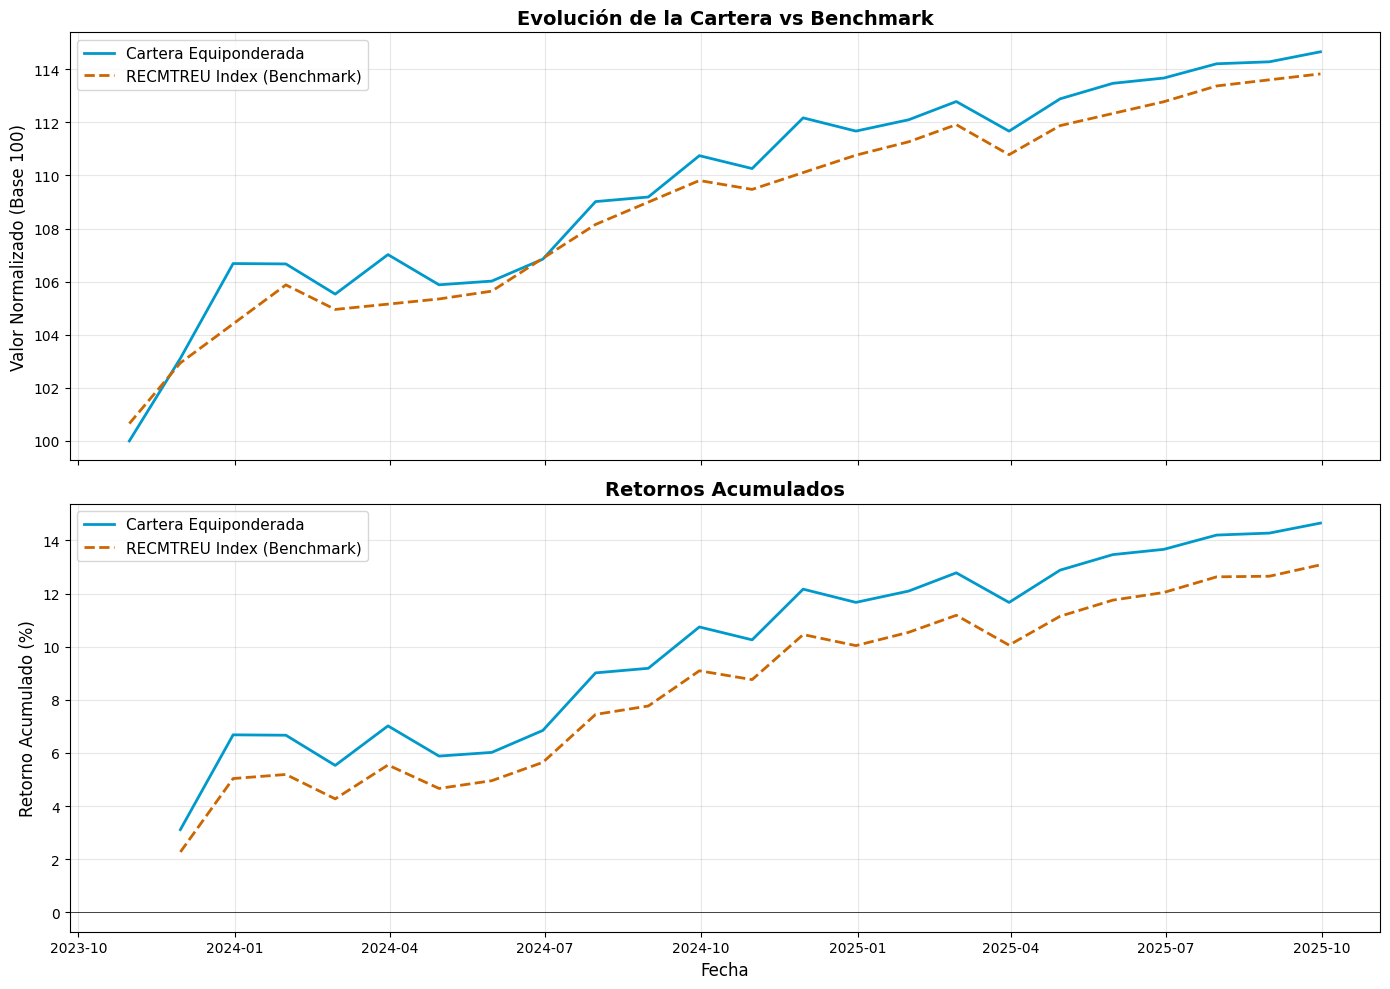

In [22]:
# Visualizar evolución de la cartera vs benchmark
# Verificar que 'results' existe (debe ejecutarse la celda anterior primero)
if 'results' not in locals() and 'results' not in globals():
    print("⚠️ Error: La variable 'results' no está definida.")
    print("Por favor, ejecuta primero la celda anterior que calcula el backtest (celda que llama a backtest_equally_weighted_portfolio).")
    print("\nPasos correctos:")
    print("1. Ejecuta la celda que carga los datos históricos")
    print("2. Ejecuta la celda que llama a backtest_equally_weighted_portfolio()")
    print("3. Luego ejecuta esta celda para visualizar los resultados")
else:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Gráfico 1: Evolución del valor
    ax1 = axes[0]
    if len(results['portfolio_value']) > 0:
        ax1.plot(results['portfolio_value'].index, results['portfolio_value'].values, 
                 label='Cartera Equiponderada', linewidth=2, color='#0099CC')
    if len(results['benchmark_value']) > 0:
        # Alinear fechas del benchmark con fechas de la cartera
        common_dates = results['portfolio_value'].index.intersection(results['benchmark_value'].index)
        if len(common_dates) > 0:
            ax1.plot(common_dates, results['benchmark_value'].loc[common_dates], 
                     label='RECMTREU Index (Benchmark)', linewidth=2, color='#CC6600', linestyle='--')

    ax1.set_title('Evolución de la Cartera vs Benchmark', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Valor Normalizado (Base 100)', fontsize=12)
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Gráfico 2: Retornos acumulados
    ax2 = axes[1]
    if len(results['portfolio_returns']) > 0:
        # Los retornos ya están en decimal, no en porcentaje
        cumulative_returns_port = (1 + results['portfolio_returns']).cumprod() - 1
        ax2.plot(cumulative_returns_port.index, cumulative_returns_port.values * 100,
                 label='Cartera Equiponderada', linewidth=2, color='#0099CC')
    if len(results['benchmark_returns']) > 0:
        common_dates = results['portfolio_returns'].index.intersection(results['benchmark_returns'].index)
        if len(common_dates) > 0:
            # Los retornos ya están en decimal, no en porcentaje
            cumulative_returns_bench = (1 + results['benchmark_returns'].loc[common_dates]).cumprod() - 1
            ax2.plot(common_dates, cumulative_returns_bench.values * 100,
                     label='RECMTREU Index (Benchmark)', linewidth=2, color='#CC6600', linestyle='--')

    ax2.set_title('Retornos Acumulados', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Fecha', fontsize=12)
    ax2.set_ylabel('Retorno Acumulado (%)', fontsize=12)
    ax2.legend(loc='best', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()


In [23]:
# Calcular y mostrar métricas de rendimiento
if len(results['portfolio_returns']) > 0 and len(results['benchmark_returns']) > 0:
    metrics = calculate_performance_metrics(
        results['portfolio_returns'],
        results['benchmark_returns']
    )
    
    print("="*60)
    print("MÉTRICAS DE RENDIMIENTO")
    print("="*60)
    print(f"\n{'Métrica':<30} {'Cartera':<20} {'Benchmark':<20}")
    print("-" * 70)
    print(f"{'Retorno Total (%)':<30} {metrics.get('portfolio_total_return', 0):<20.2f} {metrics.get('benchmark_total_return', 0):<20.2f}")
    print(f"{'Retorno Anual (%)':<30} {metrics.get('portfolio_annual_return', 0):<20.2f} {metrics.get('benchmark_annual_return', 0):<20.2f}")
    print(f"{'Volatilidad Anual (%)':<30} {metrics.get('portfolio_volatility', 0):<20.2f} {metrics.get('benchmark_volatility', 0):<20.2f}")
    print(f"{'Sharpe Ratio':<30} {metrics.get('portfolio_sharpe', 0):<20.2f} {metrics.get('benchmark_sharpe', 0):<20.2f}")
    print(f"{'Max Drawdown (%)':<30} {metrics.get('max_drawdown_portfolio', 0):<20.2f} {metrics.get('max_drawdown_benchmark', 0):<20.2f}")
    print("\nMétricas Activas:")
    print("-" * 70)
    print(f"{'Tracking Error (%)':<30} {metrics.get('tracking_error', 0):<20.2f}")
    print(f"{'Information Ratio':<30} {metrics.get('information_ratio', 0):<20.2f}")
    print(f"{'Beta':<30} {metrics.get('beta', 0):<20.2f}")
    print(f"{'Alpha (%)':<30} {metrics.get('alpha', 0):<20.2f}")
    print("="*60 + "\n")
    
    # Crear DataFrame con métricas para visualización
    metrics_df = pd.DataFrame({
        'Cartera': [
            metrics.get('portfolio_total_return', 0),
            metrics.get('portfolio_annual_return', 0),
            metrics.get('portfolio_volatility', 0),
            metrics.get('portfolio_sharpe', 0),
            metrics.get('max_drawdown_portfolio', 0)
        ],
        'Benchmark': [
            metrics.get('benchmark_total_return', 0),
            metrics.get('benchmark_annual_return', 0),
            metrics.get('benchmark_volatility', 0),
            metrics.get('benchmark_sharpe', 0),
            metrics.get('max_drawdown_benchmark', 0)
        ]
    }, index=['Retorno Total (%)', 'Retorno Anual (%)', 'Volatilidad (%)', 'Sharpe Ratio', 'Max Drawdown (%)'])
    
    print("\nComparativa de Métricas:")
    print(metrics_df)
else:
    print("⚠️ No se pudieron calcular métricas. Verifica que los datos de precios estén disponibles.")


MÉTRICAS DE RENDIMIENTO

Métrica                        Cartera              Benchmark           
----------------------------------------------------------------------
Retorno Total (%)              14.65                13.08               
Retorno Anual (%)              7.39                 6.62                
Volatilidad Anual (%)          4.11                 3.28                
Sharpe Ratio                   1.80                 2.02                
Max Drawdown (%)               -1.08                -1.01               

Métricas Activas:
----------------------------------------------------------------------
Tracking Error (%)             0.94                
Information Ratio              0.80                
Beta                           1.24                
Alpha (%)                      -0.85               


Comparativa de Métricas:
                     Cartera  Benchmark
Retorno Total (%)  14.654478  13.082216
Retorno Anual (%)   7.391344   6.620892
Volatilidad (%)     4

### 📊 Análisis de Resultados

#### ¿Qué sería lo más correcto en lugar de utilizar los precios MID?

**En lugar de precios MID, sería más correcto usar:**

1. **Precios de ejecución (execution prices)**: Los precios reales a los que se ejecutaron las operaciones en el mercado. Los precios MID son promedios teóricos que no reflejan los costos reales de transacción.

2. **Precios de salida (exit prices)**: Para una estrategia real, necesitaríamos:
   - **Bid prices** para ventas: Cuando vendemos bonos, recibimos el precio bid (más bajo)
   - **Ask prices** para compras: Cuando compramos bonos, pagamos el precio ask (más alto)
   - **Slippage**: Diferencia entre precio esperado y precio ejecutado (especialmente en bonos ilíquidos)

3. **Incluir costos de transacción**:
   - **Comisiones**: Costos fijos por operación
   - **Bid-Ask spread**: Costo implícito de la diferencia entre bid y ask
   - **Market impact**: Efecto de nuestras propias operaciones en el precio (especialmente importante en bonos menos líquidos)

4. **Total Return con reinversión de cupones**: En lugar de solo usar precios, deberíamos:
   - Considerar cupones recibidos en cada fecha
   - Reinvertir cupones al mismo rendimiento de la cartera
   - Calcular precio sucio (incluyendo cupón corrido) para transacciones

**Impacto**: Usar precios MID sobrestima la rentabilidad real, especialmente en bonos menos líquidos donde el bid-ask spread puede ser significativo (como vimos en el análisis de liquidez, algunos bonos tienen spreads >0.5 puntos).

#### ¿Se te ocurre algún otro benchmark que se podría utilizar?

**Otros benchmarks alternativos o complementarios:**

1. **Índices de renta fija corporativa EUR**:
   - **iBoxx EUR Corporates**: Índice amplio de bonos corporativos europeos
   - **Bloomberg Barclays Euro Aggregate Corporate**: Índice de bonos corporativos EUR
   - **ICE BofA Euro Corporate Index**: Similar cobertura pero metodología diferente

2. **Índices por rating**:
   - **iBoxx EUR Corporates Investment Grade**: Solo IG, útil si nuestra cartera es principalmente IG
   - **ITRAXX Main**: Índice de CDS para crédito IG (ya lo tenemos)
   - **ITRAXX XOVER**: Índice de CDS para crédito HY (ya lo tenemos)

3. **Índices por duración/maturity**:
   - **Índices de corto/medio/largo plazo**: Para comparar según el perfil de duración de nuestra cartera
   - **iBoxx EUR Short/Mid/Long**: Segmentación por vencimiento

4. **Benchmarks sintéticos**:
   - **Curva ESTR + spread medio**: Proxy teórico (curva libre de riesgo + spread promedio del universo)
   - **Cartera pasiva replicable**: Una cartera construida con reglas simples replicables

5. **Múltiples benchmarks**:
   - **Benchmark principal**: RECMTREU (Total Return)
   - **Benchmark de crédito**: ITRAXX Main (para comparar exposición a riesgo de crédito)
   - **Benchmark de tipos**: ESTR o EURIBOR (para comparar exposición a tipos de interés)

**Justificación**: Usar múltiples benchmarks permite:
- Descomponer el rendimiento en componentes (crédito vs. tipos)
- Entender mejor el origen de la rentabilidad/riesgo
- Comparar con diferentes universos de inversión

En nuestro caso, **RECMTREU** es apropiado como benchmark principal porque es un índice Total Return de bonos corporativos europeos, que coincide bien con nuestro universo de inversión.


### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

In [24]:
# 6.1. Construir cartera optimizada según el mandato
from portfolio import build_optimized_portfolio

# Verificar que tenemos las métricas necesarias (YTM, Duration)
if 'YTM' not in vivos.columns or 'Modified_Duration' not in vivos.columns:
    print("⚠️ Advertencia: Faltan métricas YTM o Modified_Duration")
    print("   Por favor, ejecuta primero las celdas del punto 4 (YTM, Duración, Convexidad)")
else:
    # Construir cartera optimizada
    portfolio_result = build_optimized_portfolio(
        universo_df=vivos,
        fecha_analisis=fecha_analisis,
        max_bonds=20,
        max_duration=3.0,
        max_hy_exposure=0.10,
        min_outstanding=500000000,
        max_weight_per_bond=0.10,
        max_weight_per_issuer=0.15,
        exclude_subordinated=True
    )
    
    if portfolio_result:
        # Mostrar cartera construida
        print("\n" + "="*70)
        print("CARTERA OPTIMIZADA CONSTRUIDA")
        print("="*70)
        
        portfolio_df = portfolio_result['portfolio_df']
        weights = portfolio_result['weights']
        metrics = portfolio_result['metrics']
        
        # Mostrar bonos seleccionados
        print(f"\nBonos seleccionados ({len(portfolio_df)}):")
        display_cols = ['ISIN', 'Description', 'Issuer', 'Rating', 'Coupon', 
                       'Modified_Duration', 'YTM', 'Price', 'Weight']
        available_cols = [col for col in display_cols if col in portfolio_df.columns]
        print(portfolio_df[available_cols].head(20).to_string())
        
        # Guardar cartera
        portfolio_df.to_csv('cartera_optimizada.csv', index=False)
        print(f"\n✓ Cartera guardada en 'cartera_optimizada.csv'")


CONSTRUCCIÓN DE CARTERA OPTIMIZADA

Fecha de análisis: 2025-10-01 00:00:00
Bonos en universo inicial: 2236
Después de filtrar por tamaño > 500M: 1443 bonos
Después de excluir subordinada: 1353 bonos
Despues de filtrar por metricas validas: 1324 bonos
Pre-filtrado: 60 candidatos seleccionados (top por YTM)

Optimizando cartera con 60 bonos elegibles...
Restricciones:
  - Máximo 20 bonos
  - Duración <= 3.0 años
  - Exposición HY <= 10%
  - Peso máximo por bono: 10%
  - Peso máximo por emisor: 15%
  - Total de restricciones: 55
  - Emisores únicos: 52

[LOG] Iniciando optimización...
[LOG] Método: SLSQP
[LOG] Iteraciones máximas: 500
[LOG] Tolerancia: 1e-6
[LOG] Optimización completada en 0.86 segundos
[LOG] Iteraciones realizadas: 21
[LOG] Evaluaciones de función: 1281
[LOG] Éxito: True
[LOG] Suma de pesos antes de normalizar: 1.000000
[LOG] Suma de pesos después de normalizar: 1.000000
[LOG] Bonos con peso > 0.1%: 12

[OK] Optimizacion completada
  Bonos seleccionados: 12
  Peso total:

##### <font color=#CC6600>Riesgo de crédito</font>

#### 6.2. ¿Añadirías alguna otra restricción?

**Sí, consideraría añadir las siguientes restricciones adicionales:**

1. **Restricción de liquidez mínima:**
   - Bid-Ask Spread máximo: Por ejemplo, excluir bonos con spread > 0.5 puntos para asegurar liquidez
   - Volumen mínimo de negociación: Aunque no tenemos estos datos, sería relevante

2. **Restricción de diversificación sectorial:**
   - Límite de exposición por sector: Por ejemplo, máximo 25-30% en un mismo sector para evitar concentración sectorial excesiva
   - Esto es especialmente relevante dado que Financial representa ~45% del universo

3. **Restricción de calidad crediticia mínima:**
   - Rating mínimo: Aunque ya limitamos HY al 10%, podríamos establecer un rating mínimo absoluto (ej. BBB-)
   - Excluir bonos "No Rated" (NR) o tratarlos con penalización adicional

4. **Restricción de vencimiento:**
   - Rango de vencimientos: Por ejemplo, bonos entre 1-7 años para evitar bonos muy cortos (reinvestment risk) o muy largos (mayor sensibilidad)

5. **Restricción de tamaño de emisión relativo:**
   - Tamaño mínimo relativo al mercado: Asegurar que las emisiones sean suficientemente grandes en relación al mercado

6. **Restricción de correlación:**
   - Límite de correlación entre bonos del mismo emisor o sector para evitar concentración de riesgo

**Justificación:** Estas restricciones adicionales ayudarían a:
- Mejorar la liquidez de la cartera (importante para rebalanceos y salidas)
- Reducir el riesgo de concentración sectorial (especialmente relevante con Financial dominando)
- Asegurar calidad crediticia mínima
- Gestionar mejor el riesgo de reinversión y sensibilidad a tipos


##### <font color=#CC6600>Riesgo de liquidez</font>

#### 6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

**Métricas para medir el riesgo de crédito:**

1. **Métricas agregadas:**
   - **PD promedio ponderada**: $\sum w_i \cdot PD_i$ donde $w_i$ es el peso y $PD_i$ la probabilidad de default del bono $i$
   - **Exposición a HY**: Ya implementada (≤10%), pero también calcular exposición por rating específico
   - **Rating promedio ponderado**: Convertir ratings a escala numérica y calcular promedio ponderado

2. **Métricas de concentración:**
   - **Concentración por emisor**: Ya implementada (≤15%), pero también calcular índice de Herfindahl por emisor
   - **Concentración por sector**: Calcular exposición por sector y detectar concentraciones
   - **Concentración por rating**: Ver distribución de exposición por rating

3. **Métricas de spread:**
   - **Spread promedio ponderado**: $\sum w_i \cdot Spread_i$ para medir prima de riesgo crediticio
   - **Spread sobre curva libre de riesgo**: Comparar con curva ESTR
   - **Worst-case spread widening**: Simular impacto de un widening de spreads (ej. +100 bps)

4. **Métricas de pérdida esperada:**
   - **Expected Loss (EL)**: $\sum w_i \cdot PD_i \cdot LGD_i \cdot EAD_i$ donde LGD es pérdida en caso de default
   - **Value at Risk (VaR) crediticio**: Pérdida potencial en un escenario estresado
   - **Credit VaR**: Basado en distribuciones de spreads y correlaciones

5. **Métricas de sensibilidad:**
   - **Sensibilidad a ITRAXX**: Correlación y beta con índices de crédito (ITRAXX Main, XOVER)
   - **Duration crediticia**: Sensibilidad del valor de la cartera a cambios en spreads

**En nuestro caso, con los datos disponibles:**
- Usaríamos PD 1YR del universo para calcular PD promedio ponderada
- Analizaríamos distribución por rating y sector
- Calcularíamos spread promedio ponderado (usando Spread_implicito_bps)
- Compararíamos exposición con ITRAXX Main/XOVER para medir sensibilidad

#### 6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

**Métricas para medir el riesgo de liquidez:**

1. **Métricas basadas en Bid-Ask Spread:**
   - **Spread promedio ponderado**: $\sum w_i \cdot Spread_i$ donde $Spread_i$ es el bid-ask spread del bono $i$
   - **Spread máximo**: Identificar el bono con mayor spread en la cartera
   - **Porcentaje de cartera con spread alto**: % de la cartera con spread > 0.5 puntos

2. **Métricas basadas en tamaño de emisión:**
   - **Outstanding promedio ponderado**: $\sum w_i \cdot Outstanding_i$
   - **Porcentaje en emisiones grandes**: % de la cartera en emisiones > 1,000M
   - **Tamaño mínimo de emisión**: Identificar la emisión más pequeña

3. **Métricas de frecuencia de negociación:**
   - **Días sin negociación**: Número de días en los últimos 30/60 días sin precio disponible
   - **Volumen promedio**: Si tuviéramos datos de volumen, calcular volumen promedio ponderado
   - **Turnover ratio**: Ratio de volumen negociado vs. outstanding

4. **Métricas de impacto de mercado:**
   - **Market Impact estimado**: Impacto estimado de vender X% de la cartera en el precio
   - **Tiempo de liquidación**: Tiempo estimado para liquidar la cartera sin impacto significativo

5. **Métricas compuestas:**
   - **Liquidity Score**: Score combinado de spread, tamaño y frecuencia
   - **Cost of Liquidity**: Costo estimado de liquidar la cartera (spread + market impact)

**Información adicional que sería útil (aunque no la tenemos):**
- **Volumen negociado diario/semanal**: Para medir frecuencia real de negociación
- **Número de dealers activos**: Cuántos market makers cotizan el bono
- **Time to trade**: Tiempo promedio para ejecutar una operación
- **Market depth**: Profundidad del libro de órdenes (bid/ask sizes)
- **Price impact histórico**: Impacto histórico de operaciones grandes en el precio
- **Correlación de liquidez**: Cómo se correlacionan los spreads en momentos de estrés

**En nuestro caso, con los datos disponibles:**
- Usaríamos Bid-Ask Spread promedio ponderado
- Outstanding Amount promedio ponderado
- Análisis de distribución de spreads en la cartera
- Comparación con el universo para ver si la cartera es más o menos líquida


##### <font color=#CC6600>Backtest</font>

#### 6.5. Describe cómo habría que hacer el backtest de esta cartera

**Metodología para el backtest de la cartera optimizada:**

1. **Inicialización:**
   - Fecha de inicio: Primera fecha disponible en precios históricos
   - Capital inicial: Normalizar a 100 (o valor específico, ej. 10M€)
   - Construir cartera inicial usando optimización con datos disponibles en fecha de inicio

2. **Rebalanceo:**
   - **Frecuencia**: Mensual o trimestral (según mandato)
   - **En cada fecha de rebalanceo:**
     a. Filtrar bonos elegibles según restricciones (vivos, con precios, cumplen restricciones)
     b. Re-optimizar cartera con datos actualizados (YTM, Duration, Ratings actuales)
     c. Calcular trades necesarios (compras/ventas)
     d. Aplicar costos de transacción (bid-ask spread, comisiones si aplica)

3. **Cálculo de retornos:**
   - **Entre rebalanceos:**
     - Calcular retorno de cada bono: $\frac{P_{t+1} - P_t + Cupones}{P_t}$
     - Retorno de cartera: $\sum w_i \cdot R_i$ donde $w_i$ son pesos y $R_i$ retornos
   - **Total Return**: Incluir cupones recibidos y reinvertirlos
   - **Precios**: Usar precios MID (o mejor, bid para ventas, ask para compras)

4. **Aplicación de restricciones dinámicas:**
   - Verificar que en cada fecha se cumplen todas las restricciones
   - Si un bono deja de cumplir restricciones (ej. rating downgrade a HY), forzar venta
   - Si la duración excede el límite, rebalancear para reducirla

5. **Métricas a calcular:**
   - Retorno total y anualizado
   - Volatilidad
   - Sharpe Ratio
   - Maximum Drawdown
   - Tracking Error vs. benchmark (RECMTREU)
   - Alpha y Beta
   - Cumplimiento de restricciones a lo largo del tiempo

6. **Consideraciones especiales:**
   - **Costos de transacción**: Incluir bid-ask spread en cada trade
   - **Slippage**: Diferencia entre precio esperado y ejecutado
   - **Market impact**: Si la cartera es grande, considerar impacto en precios
   - **Liquidez**: Si un bono no tiene precio en fecha de rebalanceo, usar último precio disponible o excluirlo

7. **Comparación con estrategias alternativas:**
   - Comparar con cartera equiponderada (punto 5)
   - Comparar con benchmark (RECMTREU)
   - Comparar con cartera pasiva que replica índice

**Diferencia clave vs. cartera equiponderada:**
- La cartera optimizada requiere re-optimización en cada rebalanceo
- Los costos de transacción pueden ser mayores (más trades)
- La composición puede cambiar más significativamente entre rebalanceos


### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>